### Machine Learning Engineering Nanodegree Capstone Project

This project aims to create a classifier to recognise characters in natural scene images using a subset of the Chars74K dataset and a Convolutional Neural Network (CNN). 

See the **Capstone Proposal** [here](capstone_proposal.pdf) 

---

### About the Chars74K dataset

The project uses a subset of the Chars74 dataset, the nature of dataset can be read about [here](http://personal.ee.surrey.ac.uk/Personal/T.Decampos/papers/decampos_etal_visapp2009.pdf).

The [Chars74K](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) dataset contains:
* 7705 characters obtained from natural images
* 3410 hand drawn characters using a tablet PC
* 62992 synthesised characters from computer fonts

This project will initially focus on the classification of the 7705 characters obtained from natural scene images.

### Whrere to get the dataset

* The download `EnglishImg.tgz` contains images of characters from natural scenes. 
* There are 7705 images in the folder `GoodImg`.
* The download `ListsTXT.tgz` and file `list_English_Img.m` contains the information of the data structure but in the "M" format. 
* This has been translated here into a simple csv, for an initial exploration of class distribution, with the columns:
    * **ALLlabels**: class label for each sample
    * **ALLnames**: sub-directory and name of the image for each sample

In [1]:
import pandas as pd
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
from io import StringIO

import os
import math
from scipy.misc import imread, imsave, imresize
# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('details/ListsGoodImg.csv')
data.head()

,ALLlabels,ALLnames
0,1,GoodImg/Bmp/Sample001/img001-00001
1,1,GoodImg/Bmp/Sample001/img001-00002
2,1,GoodImg/Bmp/Sample001/img001-00003
3,1,GoodImg/Bmp/Sample001/img001-00004
4,1,GoodImg/Bmp/Sample001/img001-00005


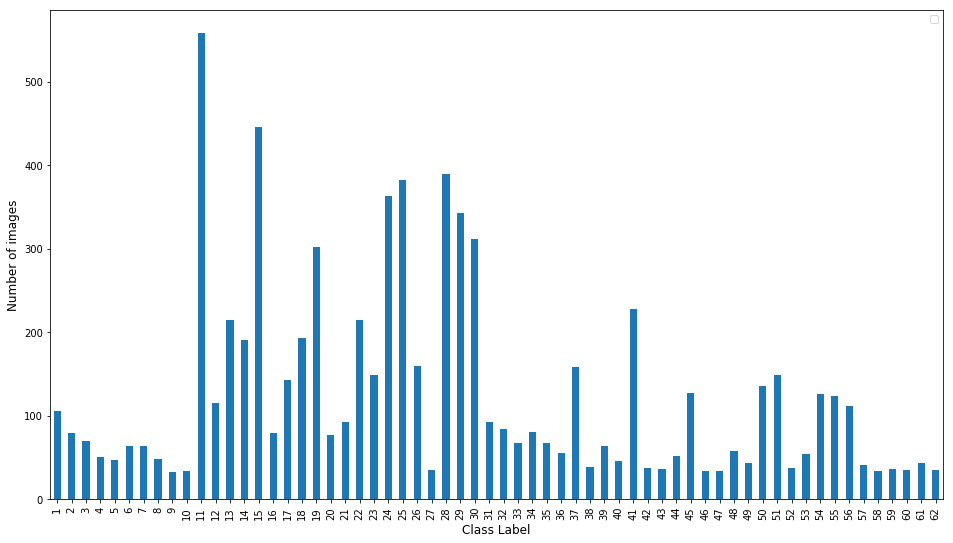

In [3]:
plt.figure(figsize=(16,9))

fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
data.groupby('ALLlabels').count().plot.bar(ylim=0)
plt.xlabel("Class Label",fontsize=12)
plt.ylabel("Number of images",fontsize=12)
plt.legend("")

As can seen above the clases in the dataset are not evenly distrbuted. The classses correspond to:

| Label  | Class |
| ---    |  ---  |
| 1-10   | 0 - 9 |
| 11-36  | A - Z |
| 37-62  | a - z |

In [4]:
# Taken from: http://ankivil.com/kaggle-first-steps-with-julia-chars74k-first-place-using-convolutional-neural-networks/
def label2int(ch):
    asciiVal = ord(ch)
    if(asciiVal<=57): #0-9
        asciiVal-=48
    elif(asciiVal<=90): #A-Z
        asciiVal-=55
    else: #a-z
        asciiVal-=61
    return asciiVal
    
def int2label(i):
    if(i<=9): #0-9
        i+=48
    elif(i<=35): #A-Z
        i+=55
    else: #a-z
        i+=61
    return chr(i)

### Exploring the images

The `GoodImg` folder is structured such that the `Bmp` folder contains samples of the 62 different classes each in their own folder such as `Sample001`. 

The code below shows all the photos from `Sample001` with is different photos of the character 0.
      
 

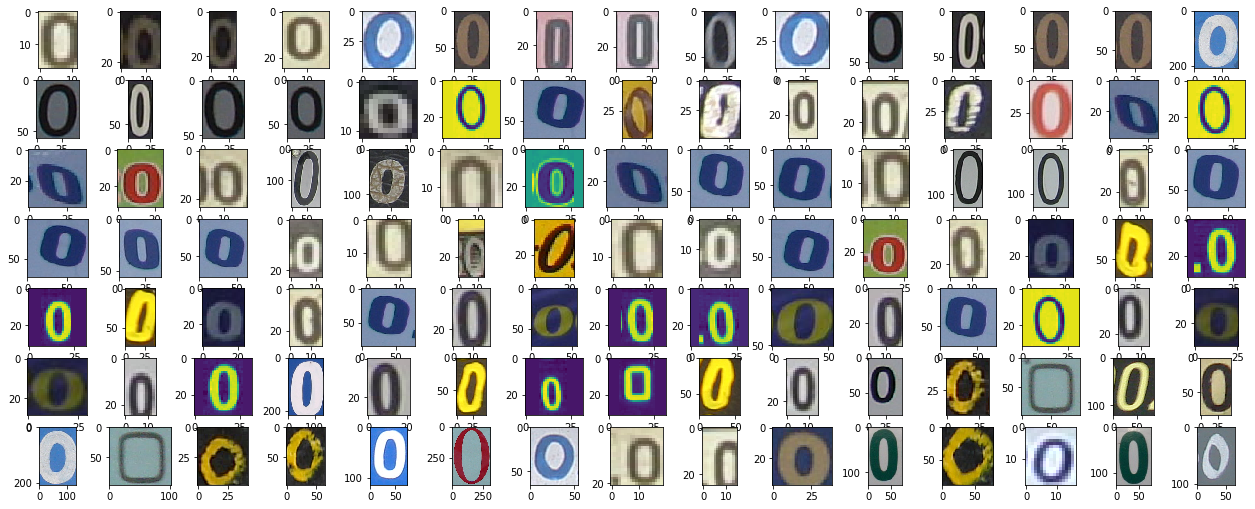

In [5]:
import glob
import matplotlib.image as mpimg
%matplotlib inline
images = []
for img_path in glob.glob('Img/GoodImg/Bmp/Sample001/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### Create training, test and validation datasets [...](https://cs230-stanford.github.io/train-dev-test-split.html)

Psudeocode

* Loop through each folder Sample001-Sample062
* Split each class into 80% training set, 10% validation set and 10% test set. 
* Save as an array of filenames for `training`, `test` and `validation` datasets. 

Why?
* **Train set** - fit the model weights
* **Validation set** - check how the model is doing
* **Test set** - check the accuracy of the trained model

In [6]:
import random

class_list = ["01", "02", "03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20", "21", "22","23","24","25","26","27","28","29","30","31","32","33","34","35","36","37","38","39","40","41","42","43","44","45","46","47","48","49","50","51","52","53","54","55","56","57","58","59","60","61","62"]
training_set= [] 
validation_set = []
test_set = []

for i in class_list:
    folder_name = "Img/GoodImg/Bmp/Sample0" + i + "/*.png"
    
    filenames = []
    for img_path in glob.glob(folder_name):
        filenames.append(img_path)

    filenames.sort()  # make sure that the filenames have a fixed order before shuffling   
    random.seed(230)
    random.shuffle(images)
        
    split_1 = int(0.8 * len(filenames))
    split_2 = int(0.9 * len(filenames))
    
    train_filenames = filenames[:split_1]
    validation_filenames = filenames[split_1:split_2]
    test_filenames = filenames[split_2:]
            
    training_set.extend(train_filenames)
    validation_set.extend(validation_filenames)
    test_set.extend(test_filenames)

print('There are %d training images.' % len(training_set))
print('There are %d validation images.' % len(validation_set))
print('There are %d test images.' % len(test_set))


There are 6140 training images.
There are 765 validation images.
There are 800 test images.


### Preprocessing [...](http://ankivil.com/kaggle-first-steps-with-julia-chars74k-first-place-using-convolutional-neural-networks/)

Create the files 
* Read the images from the array of image paths and flatten to grayscale
* Resize the image to 32*32
* Save the image to the new folder in /data
* Create the images as a numpy file for loading later

In [7]:
path = 'data'
img_rows, img_cols = 32, 32

### Create test files

In [10]:
files = test_set
test_data = np.zeros((len(files), img_rows, img_cols)) # will add the channel dimension later

for i, filepath in enumerate(files):
    image = imread(filepath, True) # True: flatten to grayscale

    imageResized = imresize(image, (img_rows, img_cols))

    # Add the resized image to the dataset
    test_data[i] = imageResized

    #Save images - Uncomment the lines below to create images
    #path_list = filepath.split(os.sep)
    #newName = 'data/test_Preproc_32_32/' + path_list[4]
    #imsave(newName, imageResized)

# Add channel/filter dimensions    
test_data = test_data[:,np.newaxis,:,:]

# We rescale the images by dividing every pixel in the image by 255
test_data = test_data.astype('float32')
test_data /= 255

# Save data as a numpy file 
np.save("data/test_preproc_32_32.npy", test_data)

### Create validation files

In [19]:
validation_files = validation_set
validation_data = np.zeros((len(validation_files), img_rows, img_cols)) # will add the channel dimension later

for i, filepath in enumerate(validation_files):
    image = imread(filepath, True) # True: flatten to grayscale

    imageResized = imresize(image, (img_rows, img_cols))

    # Add the resized image to the dataset
    validation_data[i] = imageResized

    #Save images - Uncomment the lines below to create images
    #path_list = filepath.split(os.sep)
    #newName = 'data/validation_Preporc_32_32/' + path_list[4]
    #imsave(newName, imageResized)
    
# Add channel/filter dimensions    
validation_data = validation_data[:,np.newaxis,:,:]

# We rescale the images by dividing every pixel in the image by 255
validation_data = validation_data.astype('float32')
validation_data /= 255

# Save data as a numpy file 
np.save("data/validation_preproc_32_32.npy", validation_data)

### Create training files

In [9]:
training_files = training_set
training_data = np.zeros((len(training_files), img_rows, img_cols)) # will add the channel dimension later

for i, filepath in enumerate(training_files):
    image = imread(filepath, True) # True: flatten to grayscale

    imageResized = imresize(image, (img_rows, img_cols))

    # Add the resized image to the dataset
    training_data[i] = imageResized

    #Save images - Uncomment the lines below to create images
    #path_list = filepath.split(os.sep)
    #newName = 'data/train_Preproc_32_32/' + path_list[4]
    #imsave(newName, imageResized)
    
# Add channel/filter dimensions    
training_data = training_data[:,np.newaxis,:,:]

# We rescale the images by dividing every pixel in the image by 255
training_data = training_data.astype('float32')
training_data /= 255

# Save data as a numpy file 
np.save("data/training_preproc_32_32.npy", training_data)

### Show sample processed images

Show how the sample images for character 0 have changed after simple pre-processing

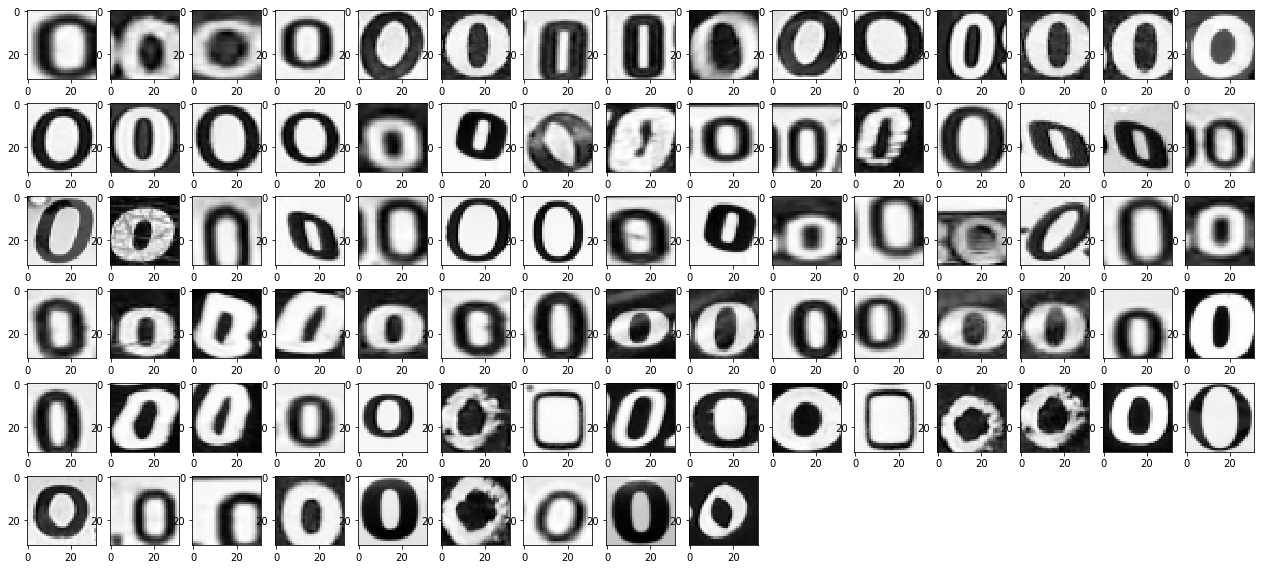

In [8]:
images = []
for img_path in glob.glob('data/train_preproc_32_32/img001-*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    # By default matplotlib uses a colormap which maps intensities to colors. 
    # `cmap='Greys_r' is used to show the image
    plt.imshow(image, cmap='Greys_r')

### Create traing labels

In [44]:
folder_name = "data/train_preproc_32_32/*.png"

y_train = []
filenames = []
for img_path in sorted(glob.glob(folder_name)):
    filenames.append(img_path)

    path_list = img_path.split(os.sep)
    img_ext = path_list[2]
    class_str = int(img_ext[3:6])
    y_train.append(class_str)

y_train_shape = len(y_train)
# Create a np array with shape (y_train_shape, 62)
Y_train = np.zeros((y_train_shape,62))

for i in range(y_train_shape):
    Y_train[i][y_train[i]-1] = 1
    
# Save training labels as a numpy file    
np.save("data/trainingLabels.npy",Y_train)

### Create validation labels

In [36]:
folder_name = "data/validation_preproc_32_32/*.png"

y_validation = []
filenames = []
for img_path in sorted(glob.glob(folder_name)):
    filenames.append(img_path)

    path_list = img_path.split(os.sep)
    img_ext = path_list[2]
    class_str = int(img_ext[3:6])
    y_validation.append(class_str)

y_validation_shape = len(y_validation)
# Create a np array 
Y_validation = np.zeros((y_validation_shape,62))

for i in range(y_validation_shape):
    Y_validation[i][y_validation[i]-1] = 1
    
# Save training labels as a numpy file    
np.save("data/validationLabels.npy",Y_validation)

### Create test labels

In [42]:
folder_name = "data/test_preproc_32_32/*.png"

y_test = []
filenames = []
for img_path in sorted(glob.glob(folder_name)):
    filenames.append(img_path)

    path_list = img_path.split(os.sep)
    img_ext = path_list[2]
    class_str = int(img_ext[3:6])
    y_test.append(class_str)

y_test_shape = len(y_test)
# Create a np array 
Y_test = np.zeros((y_test_shape,62))

for i in range(y_test_shape):
    Y_test[i][y_test[i]-1] = 1
    
# Save training labels as a numpy file    
np.save("data/testLabels.npy",Y_test)

### Load data and labels

In [9]:
X_train_all = np.load("data/training_preproc_32_32.npy")
Y_train_all = np.load("data/trainingLabels.npy")

X_validation_all = np.load("data/validation_preproc_32_32.npy")
Y_validation_all = np.load("data/validationLabels.npy")

X_test_all = np.load("data/test_preproc_32_32.npy")
Y_test_all = np.load("data/testLabels.npy")

## CNN Model

Create benchmark basic CNN architecture:

* Conv2D: 3x3 kernels | 32 maps |  relu | input shape = (1,32,32)
* MaxPooling2D | 2x2 pool size | stride=None
* Conv2D: 3x3 kernels | 64 maps |  relu
* MaxPooling2D | 2x2 pool size | stride=None
* Conv2D: 3x3 kernels | 128 maps |  relu
* MaxPooling2D | 2x2 pool size | stride=None
* Flatten layer
* Fully Connected | 64 units | relu
* Dropout (0.3)
* Fully Connected | 62 units | softmax

This architecture will easily run locally on the CPU and so can be used an initial starting point.

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras import backend as K
K.set_image_dim_ordering('th')

model = Sequential()

### Define the architecture.
model.add(Conv2D(32,(3, 3),activation='relu',input_shape=(1,32,32)))
# window size of 2*2 define for the Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(62, activation='softmax'))

model.summary() 

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 30, 30)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 15, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 13, 13)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 7, 7)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 5, 5)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 3, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

### Compile the Model

* [Usage of optimizers](https://keras.io/optimizers/) in Keras
* [Usage of Loss function](https://keras.io/losses/) in Keras

In [11]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint

epochs = 15

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(X_train_all, Y_train_all, 
          validation_data=(X_validation_all, Y_validation_all),
          epochs=epochs, batch_size=40, callbacks=[checkpointer], verbose=1)

Train on 6140 samples, validate on 765 samples
Epoch 1/15
6140/6140 [==============================] - 39s 6ms/step - loss: 3.8519 - acc: 0.0796 - val_loss: 3.6610 - val_acc: 0.0967

Epoch 00001: val_loss improved from inf to 3.66104, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/15
6140/6140 [==============================] - 34s 6ms/step - loss: 2.7037 - acc: 0.3567 - val_loss: 1.8752 - val_acc: 0.5503

Epoch 00002: val_loss improved from 3.66104 to 1.87522, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/15
6140/6140 [==============================] - 34s 6ms/step - loss: 1.6608 - acc: 0.5689 - val_loss: 1.4737 - val_acc: 0.5987

Epoch 00003: val_loss improved from 1.87522 to 1.47370, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/15
6140/6140 [==============================] - 38s 6ms/step - loss: 1.2383 - acc: 0.6666 - val_loss: 1.2088 - val_acc: 0.6719

Epoch 00004: val_loss improved from 1.47370 to 1.20882, saving mo

In [13]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [14]:
test_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in X_test_all]

# report test accuracy
test_accuracy = 100*np.sum(np.array(test_predictions)==np.argmax(Y_test_all, axis=1))/len(test_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 61.8750%


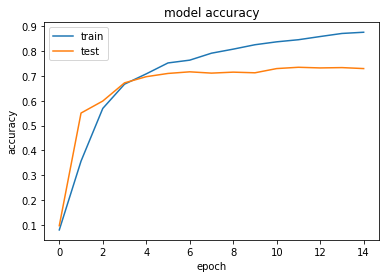

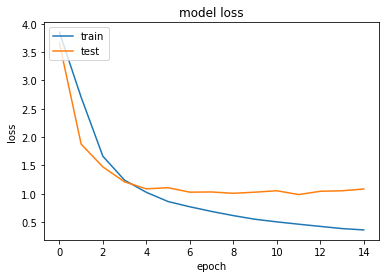

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

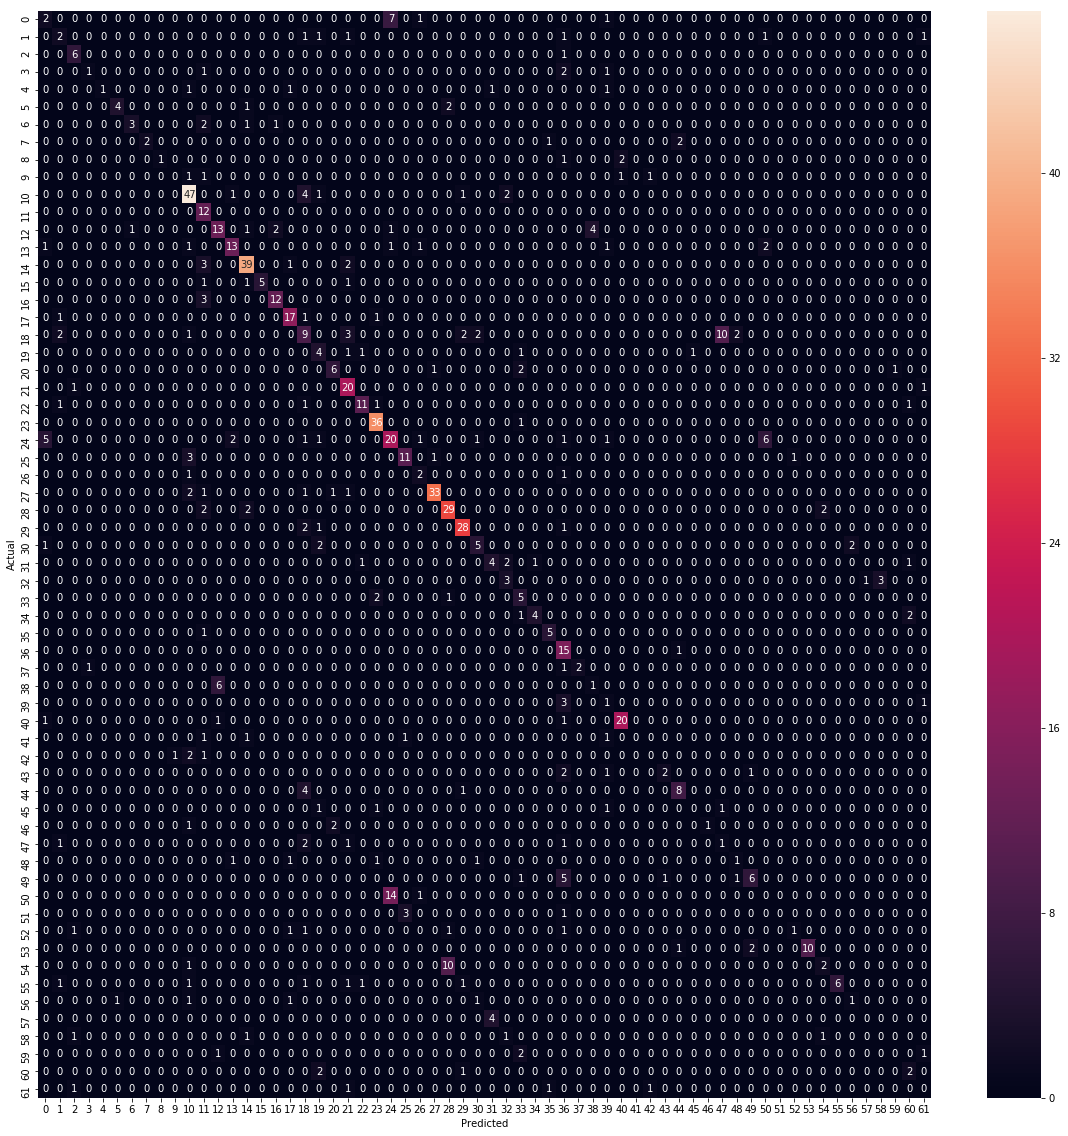

In [16]:
import seaborn as sns
y_test = np.argmax(Y_test_all, axis=1)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test,test_predictions)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
class_list = ["0","01", "02", "03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20", "21", "22","23","24","25","26","27","28","29","30","31","32","33","34","35","36","37","38","39","40","41","42","43","44","45","46","47","48","49","50","51","52","53","54","55","56","57","58","59","60","61"]
from sklearn import metrics
print(metrics.classification_report(y_test, test_predictions, target_names=class_list))

             precision    recall  f1-score   support

          0       0.20      0.18      0.19        11
         01       0.25      0.25      0.25         8
         02       0.60      0.86      0.71         7
         03       0.50      0.20      0.29         5
         04       1.00      0.20      0.33         5
         05       0.80      0.57      0.67         7
         06       0.75      0.43      0.55         7
         07       1.00      0.40      0.57         5
         08       1.00      0.25      0.40         4
         09       0.00      0.00      0.00         4
         10       0.75      0.84      0.79        56
         11       0.41      1.00      0.59        12
         12       0.62      0.59      0.60        22
         13       0.76      0.65      0.70        20
         14       0.83      0.87      0.85        45
         15       1.00      0.62      0.77         8
         16       0.80      0.80      0.80        15
         17       0.77      0.85      0.81   

### Show examples of images with model predictions

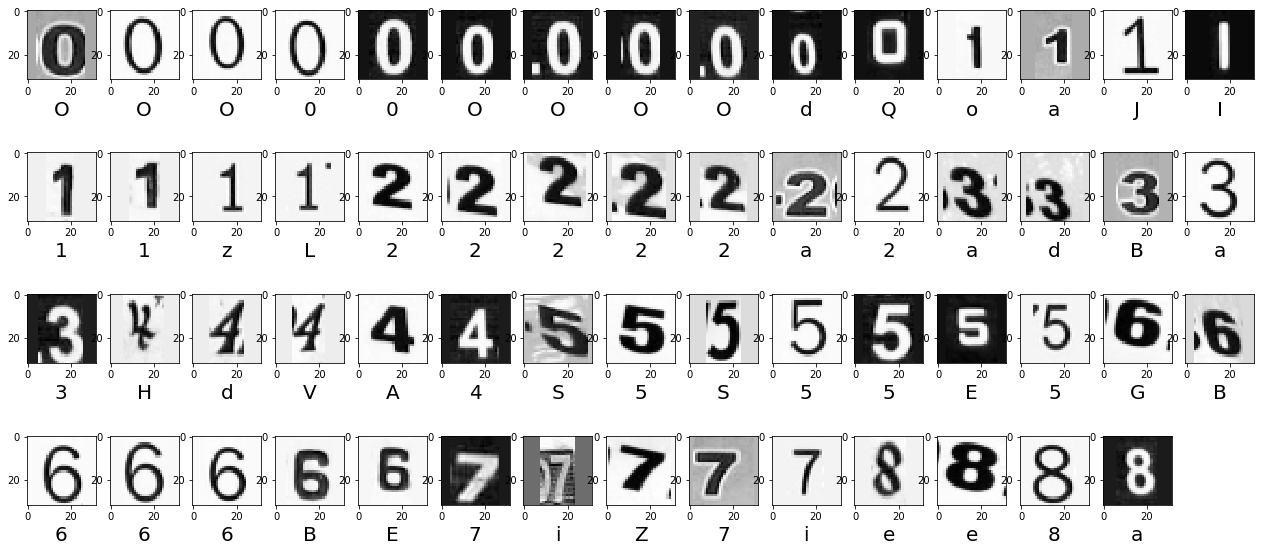

In [18]:
Y_test = np.argmax(Y_test_all, axis=1)

images = []
for img_path in sorted(glob.glob('data/test_preproc_32_32/img00*-*.png')):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.xlabel(int2label(test_predictions[i]),fontsize=20)
    plt.imshow(image, cmap='Greys_r')

### Initial model performance

The final accuracy of this initial exploratory model is around **65%** with an F1-score of **63%**. 

* A number of misclassified images are actually the lowercase/uppercase equivalent such as `S/s, N/n, c/C`.
* `0` are largely misclassified as `O`, this is likely due to the class imblance between `0` and `O` in the initial training set. 
* The model performs well on distinctive characters like `E`, only misclassifying one character as `L`. This is no surprise as `E` has a distinctive pattern that would be well represented by a CNN.
* It's likely that the CNN architecture is underfitting

### Data Augmentation [...](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

This shows how data augmentation can be applied in the next step.

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* `shear_range` is for randomly applying shearing transformations
* `zoom_range` is for randomly zooming inside pictures
* `horizontal_flip` is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [19]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train_preproc_32_32/img001-00001.png')
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', 
                          save_prefix='test',
                          save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

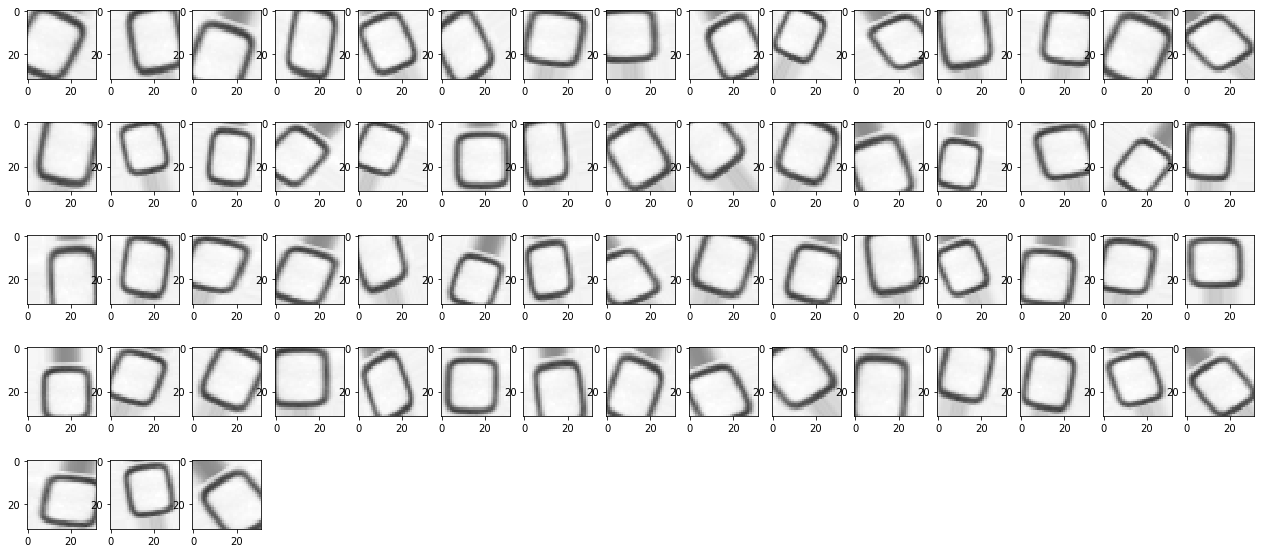

In [20]:
images = []
for img_path in sorted(glob.glob('preview/*.png')):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image, cmap='Greys_r')